In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sn
import random

In [ ]:
df_train_orig = pd.read_csv("data/DA_titanic_train.csv")
df_test_orig = pd.read_csv("data/DA_titanic_test.csv")
df_train = df_train_orig.copy(deep=True)
df_test = df_test_orig.copy(deep=True)

## Adatok megismerése

In [ ]:
df_train.info()

In [4]:
df_train.describe()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,624.000000,624.000000,624.000000,494.000000,624.000000,624.000000,624.000000
mean,459.128205,0.383013,2.328526,29.658745,0.519231,0.354167,30.523470
std,257.314092,0.486511,0.822684,14.770773,1.071871,0.775559,48.186064
min,1.000000,0.000000,1.000000,0.670000,0.000000,0.000000,0.000000
25%,241.750000,0.000000,2.000000,20.000000,0.000000,0.000000,7.895800
50%,460.500000,0.000000,3.000000,28.000000,0.000000,0.000000,13.931250
75%,683.250000,1.000000,3.000000,38.000000,1.000000,0.000000,30.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
df_train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
4,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C
5,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
6,13,0,3,"Saundercock, Mr. William Henry",male,20.0,0,0,A/5. 2151,8.0500,NaN,S
7,14,0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.2750,NaN,S
8,15,0,3,"Vestrom, Miss. Hulda Amanda Adolfina",female,14.0,0,0,350406,7.8542,NaN,S
9,16,1,2,"Hewlett, Mrs. (Mary D Kingcome)",female,55.0,0,0,248706,16.0000,NaN,S


A train adatokat első körben megvizsgálva látható, hogy 3 oszlop tartalmaz hiányos adatokat: az összesen 624 utas közül csak 494-nek ismerük a korát, 128-nak a cabin számát és 623-nak a felszállás helyét.

A PassengerId az utas egyedi azonosítója, egy integer. Mivel ez az adatbázisban elfoglalt helyét mutatja csak meg az utasnak, ezért várhatóan ezt nem fogom felhasználni.

A Survived alapján osztályozzuk az utasokat, értéke 0, amennyiben áldozat, 1 amennyiben túlélő. Összesen az utasok 38.3%-a élte túl a balesetet, tehát ez egy kiegyensúlyozatlan adathalmaz.

A Pclass fejezi ki, milyen osztályra szólt a jegye. Értéke 1,2,3 számok közül kerül ki, amely kifejezi, hogy melyik osztályon utazott. Kategórikus érték, ezért lehet érdemes külön oszlopokban one-hot vektorként tárolni.

A Name az utas neve. Elsőként a vezetéknév, vagy vezetéknevek szerepelnek, majd vessző után az utas titulusa, majd a keresztnevek, leánykori nevek, becenevek szerepelnek. A titulus információként szolgálhat az utas családi állapotáról, nemesi rangjáról, amely befolyásolhatta a túlélési esélyeit, ezt érdemes lehet külön attribútumként tárolni.

A Sex az utas neme, male abban az esetben ha férfi, female abban az esetben ha nő, ezt bináris értékké konvertálom.

Az Age az utas kora években mérve, értéke 0.67 (8 hónap) és 80 között van.

A SibSp az utas fedélzeten lévő testvéreinek és házastársainak a száma.

A Parch az utas fedélzeten lévő szüleinek és gyerekeinek a száma.

A Ticket az utas jegyének a számát jelenti. Nem találtam egységes szabályt a jelentésére, a szám valószínűleg egy azonosító, az előtte lévő karakterek pedig amennyiben vannak, a jegy vételét azonosíthatják, néhány esetben város névvel. Több utasnak is lehet ugyanaz a jegye, amely szintén az utasok közötti kapcsolatnak egy jele, amely befolyásolhatja a túlélési esélyüket. Ez azonban egy olyan tulajdonság, amely hiányos adatok esetén hamis adatokat eredményez, így használhatósága kérdéses.

A Fare a jegyért fizetett összeg, lebegőpontos szám. Egy jegy több személyre is szólhat, ezért a személyenkénti árat megkaphatjuk, ha elosztjuk az árat azzal hány emberre szól a jegy. Mivel ez utóbbi információ függ attól, hogy az adatbázis mennyire teljes, a használhatósága ennek a számnak kérdéses. Ehelyett lehet a hajón lévő rokonok számával elosztani a jegyárat, amely megbíthatóbban minden utasról rendelkezésre áll.

A Cabin az utas kabinjának a száma. Az első karakter a fedélzetet, az utána következő szám pedig a kabin szinten belüli elhelyezkedését jelenti. Az utas kabinjának elhelyezkedése befolyásolatta a túlélés esélyét, azonban ez egy nagyon hiányos információ, így kétséges hogy mennyire lehet felhasználni. Néhány utas esetén több kabin is meg van adva, ezek egymáshoz közel helyezkednek, így ez esetben az első megadott kabint fogom választani. Több utas is lehet ugyanabban a kabinban, ami szintén befolyásolhatta a túlélési esélyeiket, azonban itt még inkább hiányosak az adatok, így ennek a használhatósága is kérdéses. A kabin szintje kategórikus adat, ezért ezt szintén one-hot vektorkénttárolom.

Az Embarked a hajóra felszállás helyét jelöli, C karakter Cherbourg, Q karakter Queenstown, S karakter Southampton. Mint kategórikus adat, szintén one-hot vektorként tárolom az értékét.




## Adatok átalakítása

In [6]:
from collections import Counter
def transform_database(df_: pd.DataFrame):
    df = df_.copy(deep=True)
    df["Sex"] = (df["Sex"] == "female") * 1


    cabin_elements = Counter(df["Cabin"])
    cabin_elements[np.nan] = 1
    ticket_elements = Counter(df["Ticket"])

    df["NoCabin"] = df["Cabin"]
    df["NoTicket"] = df["Ticket"]
    df = df.replace({"NoCabin": cabin_elements, "NoTicket": ticket_elements})
    df["Relatives"] = df["SibSp"] + df["Parch"]
    df["Deck"] = df["Cabin"].str.slice(0,1)
    df["Room"] = df["Cabin"].str.slice(1,5).str.extract("([0-9]+)", expand=False).astype("float")
    df["Title"] = df["Name"].str.split(",").str[1].str.split(".").str[0].str.strip()
    df["UnitFare"] = df["Fare"]/df["NoTicket"] 
    df["FareFamily"] = df["Fare"]/(df["Relatives"]+1)
    
    
    df["Alone"] = (df["Relatives"] == 0)*1
    return df

Első lépésként átkonvertálom a nem adatait számokká, kiszámolom hogy egy személy hány másik személlyel volt együtt egy kabinban, hány másik személlyel osztozott a jegyén, melyik szinten és szobában lakott, mi volt a titulusa, a jegy árából mennyi esett rá, mennyi rokona volt a fedélzeten összesen, a jegye árából egy fedélzeten lévő rokonai közül egy főre mekkora összeg esett, illetve egyedül volt-e rokona a fedélzeten.

In [7]:
df_train = transform_database(df_train_orig)
df_test = transform_database(df_test_orig)

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624 entries, 0 to 623
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  624 non-null    int64  
 1   Survived     624 non-null    int64  
 2   Pclass       624 non-null    int64  
 3   Name         624 non-null    object 
 4   Sex          624 non-null    int32  
 5   Age          494 non-null    float64
 6   SibSp        624 non-null    int64  
 7   Parch        624 non-null    int64  
 8   Ticket       624 non-null    object 
 9   Fare         624 non-null    float64
 10  Cabin        128 non-null    object 
 11  Embarked     623 non-null    object 
 12  NoCabin      624 non-null    int64  
 13  NoTicket     624 non-null    int64  
 14  Relatives    624 non-null    int64  
 15  Deck         128 non-null    object 
 16  Room         125 non-null    float64
 17  Title        624 non-null    object 
 18  UnitFare     624 non-null    float64
 19  FareFami

Az Embarked oszlopban egyetlen hiányzó adat van, itt egyszerűen a leggyakoribb felszállással fogom kiegészíteni az adatot.

Az Age várhatóan egy fontos információ, azonban nagyon sok a hiányzó adat. A kora eldöntésében segíthet a neve, egyrészt a titulusa, másrészt a vezetéknév segíthet a család azonosításában, ahol a többi családtagjának a SibSp, Parch oszlopainak, valamint a korának a segítségével kitalálhatjuk, milyen korosztályhoz tartozik az utas. Ez utóbbi a megoldás időigényes, ezért első lépésnek a titulusából, a neméből, valamint az osztályából teszek becslést a korára.

In [9]:
df_train.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,NoCabin,NoTicket,Relatives,Room,UnitFare,FareFamily,Alone
count,624.000000,624.000000,624.000000,624.000000,494.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,125.000000,624.000000,624.000000,624.000000
mean,459.128205,0.383013,2.328526,0.365385,29.658745,0.519231,0.354167,30.523470,1.102564,1.500000,0.873397,46.384000,20.320522,19.267290,0.612179
std,257.314092,0.486511,0.822684,0.481924,14.770773,1.071871,0.775559,48.186064,0.434167,0.941294,1.572740,33.383593,26.871582,34.415324,0.487644
min,1.000000,0.000000,1.000000,0.000000,0.670000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000
25%,241.750000,0.000000,2.000000,0.000000,20.000000,0.000000,0.000000,7.895800,1.000000,1.000000,0.000000,22.000000,7.775000,7.250000,0.000000
50%,460.500000,0.000000,3.000000,0.000000,28.000000,0.000000,0.000000,13.931250,1.000000,1.000000,0.000000,36.000000,10.500000,8.050000,1.000000
75%,683.250000,1.000000,3.000000,1.000000,38.000000,1.000000,0.000000,30.000000,1.000000,2.000000,1.000000,68.000000,23.287500,16.200000,1.000000
max,891.000000,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,4.000000,5.000000,10.000000,128.000000,256.164600,512.329200,1.000000


In [10]:
print(Counter(df_train["Title"]))

Counter({'Mr': 357, 'Miss': 128, 'Mrs': 94, 'Master': 24, 'Rev': 5, 'Dr': 5, 'Major': 2, 'Mlle': 2, 'Don': 1, 'Ms': 1, 'Lady': 1, 'Col': 1, 'Capt': 1, 'the Countess': 1, 'Jonkheer': 1})


In [11]:
df_train.groupby([ "Sex", "Pclass","Title"]).mean()["Age"]

Sex  Pclass  Title       
0    1       Capt            70.000000
             Col             56.000000
             Don             40.000000
             Dr              50.000000
             Jonkheer        38.000000
             Major           48.500000
             Master           2.460000
             Mr              44.254717
     2       Dr              38.500000
             Master           2.416667
             Mr              31.853448
             Rev             46.400000
     3       Master           6.733333
             Mr              28.145570
1    1       Dr              49.000000
             Lady            48.000000
             Miss            31.760000
             Mlle            24.000000
             Mrs             40.555556
             the Countess    33.000000
     2       Miss            22.239130
             Mrs             33.733333
             Ms              28.000000
     3       Miss            15.500000
             Mrs             32.958333

In [12]:
df_train.groupby([ "Sex", "Pclass","Title",]).std()["Age"]

Sex  Pclass  Title       
0    1       Capt                  NaN
             Col                   NaN
             Don                   NaN
             Dr                    NaN
             Jonkheer              NaN
             Major            4.949747
             Master           2.177889
             Mr              14.614805
     2       Dr              21.920310
             Master           2.866919
             Mr              11.268653
             Rev             11.717508
     3       Master           3.326660
             Mr              10.501638
1    1       Dr                    NaN
             Lady                  NaN
             Miss            11.211155
             Mlle             0.000000
             Mrs             13.757049
             the Countess          NaN
     2       Miss            13.604703
             Mrs             10.824408
             Ms                    NaN
     3       Miss             9.935731
             Mrs             10.263821

In [13]:
df_train.groupby([ "Sex", "Pclass","Title",]).count()["Age"]

Sex  Pclass  Title       
0    1       Capt              1
             Col               1
             Don               1
             Dr                1
             Jonkheer          1
             Major             2
             Master            2
             Mr               53
     2       Dr                2
             Master            6
             Mr               58
             Rev               5
     3       Master           15
             Mr              158
1    1       Dr                1
             Lady              1
             Miss             25
             Mlle              2
             Mrs              27
             the Countess      1
     2       Miss             23
             Mrs              30
             Ms                1
     3       Miss             53
             Mrs              24
Name: Age, dtype: int64

A különböző korú, titulusú és osztályú utasokat elemezve már jobban meg tudjuk becsülni az utasok korát.

Egy érdekes észrevétel, hogy várakozásaimmal ellentétben a Master előtag fiatal fiúgyerekek titulusa, elsősorban az alacsonyabb osztályúaké. Általánosságban a jobb osztályokon idősebbek, a kevésbé jó osztályokon fiatalabbak utaztak, ez különösen szembetűnő a Miss előtagóaknál, ahol az első osztályon 31.76 az átlagéletkor, a 3. osztályon pedig 15.5. Az Mrs előtagú nőknél is megfigyelhető ez, míg az 1. osztályon 40.56 az átlagéletkor a 3. osztályon 32.95, ahogy az Mr előtagú férfiaknál is az elsőosztályon 44.25, a harmadosztályon 28.14 volt az átlag életkor. Kevés az adat, de jellemzően, akiknek a fentieken kívül egyéb titulusuk van, némileg idősebbek a nemük és osztályukon belül.

Ennek megfelelően a Mr, Mrs, Miss és Master külön kezelem, a többi titulust pedig egyben, és az osztályuknak megfelelő átlagot rendelem az ismeretlen korú utasukhoz.


In [14]:
from collections import Counter
def transform_database(df_: pd.DataFrame):
    df = df_.copy(deep=True)
    df["Sex"] = (df["Sex"] == "female") * 1


    cabin_elements = Counter(df["Cabin"])
    cabin_elements[np.nan] = 1
    ticket_elements = Counter(df["Ticket"])

    df["NoCabin"] = df["Cabin"]
    df["NoTicket"] = df["Ticket"]
    df = df.replace({"NoCabin": cabin_elements, "NoTicket": ticket_elements})
    df["Relatives"] = df["SibSp"] + df["Parch"]
    df["Deck"] = df["Cabin"].str.slice(0,1)
    df["Room"] = df["Cabin"].str.slice(1,5).str.extract("([0-9]+)", expand=False).astype("float")
    df["Title"] = df["Name"].str.split(",").str[1].str.split(".").str[0].str.strip()
    df["UnitFare"] = df["Fare"]/df["NoTicket"] 
    df["FareFamily"] = df["Fare"]/(df["Relatives"]+1)
    
    
    df["Alone"] = (df["Relatives"] == 0)*1
    
    title_map = dict()
    title_map["Mr"] = "Mr"
    title_map["Mrs"] = "Mrs"
    title_map["Miss"] = "Miss"
    title_map["Master"] = "Master"

    for key in Counter(df["Title"]).keys():
        if not key in title_map.keys():
            title_map[key] = "Other"

    df = df.replace({"Title": title_map})
    df_train_orig_copy = df_train_orig.copy(deep=True)
    df_train_orig_copy["Title"] = df_train_orig_copy["Name"].str.split(",").str[1].str.split(".").str[0].str.strip()
    df_train_orig_copy = df_train_orig_copy.replace({"Title": title_map})
    df_train_orig_copy["Sex"] = (df_train_orig_copy["Sex"] == "female") * 1
    
    age_map = df_train_orig_copy.groupby([ "Sex", "Pclass","Title"]).mean()["Age"].to_dict()  # df_train is intentional

    for index, row in df[df["Age"].isnull()].iterrows():
        df.at[index, "Age"] = age_map[(row["Sex"], row["Pclass"],row["Title"],)]
        
    return df

In [15]:
df_train = transform_database(df_train_orig)
df_test = transform_database(df_test_orig)

In [16]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624 entries, 0 to 623
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  624 non-null    int64  
 1   Survived     624 non-null    int64  
 2   Pclass       624 non-null    int64  
 3   Name         624 non-null    object 
 4   Sex          624 non-null    int32  
 5   Age          624 non-null    float64
 6   SibSp        624 non-null    int64  
 7   Parch        624 non-null    int64  
 8   Ticket       624 non-null    object 
 9   Fare         624 non-null    float64
 10  Cabin        128 non-null    object 
 11  Embarked     623 non-null    object 
 12  NoCabin      624 non-null    int64  
 13  NoTicket     624 non-null    int64  
 14  Relatives    624 non-null    int64  
 15  Deck         128 non-null    object 
 16  Room         125 non-null    float64
 17  Title        624 non-null    object 
 18  UnitFare     624 non-null    float64
 19  FareFami

In [17]:
df_train.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,NoCabin,NoTicket,Relatives,Room,UnitFare,FareFamily,Alone
count,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,125.000000,624.000000,624.000000,624.000000
mean,459.128205,0.383013,2.328526,0.365385,29.439382,0.519231,0.354167,30.523470,1.102564,1.500000,0.873397,46.384000,20.320522,19.267290,0.612179
std,257.314092,0.486511,0.822684,0.481924,13.731566,1.071871,0.775559,48.186064,0.434167,0.941294,1.572740,33.383593,26.871582,34.415324,0.487644
min,1.000000,0.000000,1.000000,0.000000,0.670000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000
25%,241.750000,0.000000,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,1.000000,1.000000,0.000000,22.000000,7.775000,7.250000,0.000000
50%,460.500000,0.000000,3.000000,0.000000,28.145570,0.000000,0.000000,13.931250,1.000000,1.000000,0.000000,36.000000,10.500000,8.050000,1.000000
75%,683.250000,1.000000,3.000000,1.000000,36.000000,1.000000,0.000000,30.000000,1.000000,2.000000,1.000000,68.000000,23.287500,16.200000,1.000000
max,891.000000,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,4.000000,5.000000,10.000000,128.000000,256.164600,512.329200,1.000000


In [18]:
df_train[["Pclass", "Deck", "Room"]].groupby(["Pclass", "Deck"]).min()[["Room"]]

Room
Pclass Deck      
1      A      5.0
       B      3.0
       C      2.0
       D      9.0
       E      8.0
2      D      NaN
       E     77.0
       F      2.0
3      F     38.0
       G      6.0

In [19]:
df_train[["Pclass", "Deck", "Room"]].groupby(["Pclass", "Deck"]).max()[["Room"]]

Room
Pclass Deck       
1      A      36.0
       B     102.0
       C     128.0
       D      50.0
       E      67.0
2      D       NaN
       E     101.0
       F      33.0
3      F      73.0
       G       6.0

In [20]:
df_train[["Pclass", "Deck", "Room"]].groupby(["Pclass", "Deck"]).median()[["Room"]]

Room
Pclass Deck       
1      A      23.5
       B      50.0
       C      65.0
       D      27.0
       E      34.0
2      D       NaN
       E     101.0
       F       4.0
3      F      63.0
       G       6.0

A hiányzó kabin adatok miatt a Deck és a Room adatk nagyon hiányosak. A szoba számát a szint, illetve az osztály befolyásolhatja, valószínűleg szinten belül is a különböző osztályok tagjait igeykeztek elszeparálni egymástól.

Látható, hogy azokon a szinteken, ahol több különböző osztály tagjai is laktak, a jobb osztályokon a alacsonyabb számú szobát kaptak az utasok.
A szobák számát tehát random egész számokkal töltöm fel, ahol az első osztály esetén az A szinten 5-36, a B szinten 3-102, C szinten 2-128, D sznten 9-50, E szinten 8-67 között vehetnek fel értékeket.
A másodosztály utasainál a D szinten 50-100, E szinten 77-101, F szinten 2-33 között vehetnek fel értékeket.
A harmadosztály utasainál az F szinten 38-73, G szinten 6-50 között vehetnek fel értékeket.

Ehhez azonban minden utasról tudni kell a kabin szintjét.

A jegyárat valószínűleg a kabin elhelyezkedése, a megvásárolt osztály, illetve a felszállás helye határozhatja meg. Egy jegy több személyre is szólhat, azonban mivel nem tudunk az összes utasról információt, ezért az ár, az ismert egységár, illetve a jegyár egy családtagra eső részét is célszerű vizsgálni.

A kabin betűjele fentről lefelé növekszik, az A a legmagasabb, a G a legalacsonyabb szint (amelyik szállított utasokat), ezzel arányos a kabinok minősége is. A jegyárak ezt azonban nem követik le teljesen, a B és C szint drágább, mint az A, amelynek az ára a D és E szintek árában van.


In [21]:
df_train.groupby(["Pclass", "Deck"]).mean()[["Fare", "UnitFare", "FareFamily"]]

Fare   UnitFare  FareFamily
Pclass Deck                                   
1      A      39.275342  39.275342   33.077658
       B     124.391669  83.576765   81.750402
       C     106.412373  54.601936   53.163193
       D      60.459380  44.975210   36.732330
       E      56.117326  41.951537   35.668569
2      D      13.222233  13.222233   13.222233
       E      11.587500  10.275000   11.587500
       F      28.625000  18.875000    9.666667
3      F       7.683333   7.683333    7.683333
       G      13.581250   6.790625    4.963021

In [22]:
df_train.groupby(["Pclass", "Deck"]).count()["Fare"]

Pclass  Deck
1       A       12
        B       26
        C       33
        D       20
        E       19
2       D        3
        E        4
        F        4
3       F        3
        G        4
Name: Fare, dtype: int64

In [23]:
df_train.groupby(["Pclass", "Deck", "Embarked"]).count()[["Fare", "UnitFare", "FareFamily"]]

Fare  UnitFare  FareFamily
Pclass Deck Embarked                            
1      A    C            5         5           5
            S            7         7           7
       B    C           11        11          11
            S           14        14          14
       C    C           13        13          13
            Q            1         1           1
            S           19        19          19
       D    C            8         8           8
            S           12        12          12
       E    C            5         5           5
            S           14        14          14
2      D    C            2         2           2
            S            1         1           1
       E    Q            1         1           1
            S            3         3           3
       F    S            4         4           4
3      F    Q            1         1           1
            S            2         2           2
       G    S            4         4           4

In [24]:
df_train[(df_train["Pclass"]!=1) & (~df_train["Deck"].isnull())][["Pclass", "Deck", "Fare", "UnitFare", "FareFamily"]].sort_values(["Pclass", "Deck"])

,Pclass,Deck,Fare,UnitFare,FareFamily
190,2,D,12.8750,12.87500,12.875000
214,2,D,13.0000,13.00000,13.000000
319,2,D,13.7917,13.79170,13.791700
80,2,E,13.0000,13.00000,13.000000
197,2,E,12.3500,12.35000,12.350000
494,2,E,10.5000,10.50000,10.500000
531,2,E,10.5000,5.25000,10.500000
95,2,F,26.0000,26.00000,8.666667
115,2,F,39.0000,19.50000,9.750000
349,2,F,10.5000,10.50000,10.500000


Kabin információ elsősorban az 1. osztály utasairól áll rendelkezésre. A hajó a Southhampton - Cherbourg - Queenstown, azonban az árak nem arányosak a megtett távolsággal, az első osztály utasai mind egységárban, mind jegyárban többet fizettek Cherbourg-ból indulva, mint Southhamptonból.

Queenstown-ból érkező utasok esetén nagyon keveseknek tudjuk a kabinját, valamint a 2. és 3. osztály utasai közül is nagyon kevésnek ismerjük a kabinját, így összességében a Deck értékét az osztály és az átlagos jegyár maximuma alapján határozom meg.

Harmadosztály esetén az F szintre 7.65-7.75 volt a jegyár, nekik nem volt rokonuk. A G szintre a 3. osztály esetén drágább volt a jegy, azonban az átlagos jegyár, illetve egy családtagra jutó jegyár is kevesebb (maximum 5.5). 3. osztályú utas esetén ezért a 6.5 alatti egy családtagra jutó jegyárak esetén a G szint, efelett pedig az F szintre osztom.

Másodosztály esetén FareFamily > 13 esetén a D szintre, FareFamily > 10 esetén az E szintre, alatta az F szintre osztom.

Elsőosztály esetén FareFamily > 60 esetén B, FareFamily > 45 esetén C, FareFamily > 35 esetén A, FareFamily > 30 esetén D, alatta E szintre osztom be az embereket.

A FareFamily-t azért választottam, mivel egy utas esetén ennek értéke nem függ az adatbázisban lévő többi utastól, mint a UnitFare, azonban figyelembe veszi, hogy a jegyár költsége nem egyedül az utast terheli.

In [25]:
from collections import Counter
def transform_database(df_: pd.DataFrame):
    df = df_.copy(deep=True)
    df["Sex"] = (df["Sex"] == "female") * 1


    cabin_elements = Counter(df["Cabin"])
    cabin_elements[np.nan] = 1
    ticket_elements = Counter(df["Ticket"])

    df["NoCabin"] = df["Cabin"]
    df["NoTicket"] = df["Ticket"]
    df = df.replace({"NoCabin": cabin_elements, "NoTicket": ticket_elements})
    df["Relatives"] = df["SibSp"] + df["Parch"]
    df["Deck"] = df["Cabin"].str.slice(0,1)
    df["Room"] = df["Cabin"].str.slice(1,5).str.extract("([0-9]+)", expand=False).astype("float")
    df["Title"] = df["Name"].str.split(",").str[1].str.split(".").str[0].str.strip()
    df["UnitFare"] = df["Fare"]/df["NoTicket"] 
    df["FareFamily"] = df["Fare"]/(df["Relatives"]+1)
    
    
    df["Alone"] = (df["Relatives"] == 0)*1
    
    title_map = dict()
    title_map["Mr"] = "Mr"
    title_map["Mrs"] = "Mrs"
    title_map["Miss"] = "Miss"
    title_map["Master"] = "Master"

    for key in Counter(df["Title"]).keys():
        if not key in title_map.keys():
            title_map[key] = "Other"

    df = df.replace({"Title": title_map})
    df_train_orig_copy = df_train_orig.copy(deep=True)
    df_train_orig_copy["Title"] = df_train_orig_copy["Name"].str.split(",").str[1].str.split(".").str[0].str.strip()
    df_train_orig_copy = df_train_orig_copy.replace({"Title": title_map})
    df_train_orig_copy["Sex"] = (df_train_orig_copy["Sex"] == "female") * 1
    
    age_map = df_train_orig_copy.groupby([ "Sex", "Pclass","Title"]).mean()["Age"].to_dict()  # df_train is intentional

    for index, row in df[df["Age"].isnull()].iterrows():
        df.at[index, "Age"] = age_map[(row["Sex"], row["Pclass"],row["Title"],)]
        
    for index, row in df[df["Deck"].isnull()].iterrows():
        if row["Pclass"] == 1:
            if row["FareFamily"] > 60:
                df.at[index, "Deck"] = "B"
            elif row["FareFamily"] > 45:
                df.at[index, "Deck"] = "C"
            elif row["FareFamily"] > 35:
                df.at[index, "Deck"] = "A"
            elif row["FareFamily"] > 30:
                df.at[index, "Deck"] = "D"
            else:
                df.at[index, "Deck"] = "E"
        if row["Pclass"] == 2:
            if row["FareFamily"] > 13:
                df.at[index, "Deck"] = "D"
            elif row["FareFamily"] > 10:
                df.at[index, "Deck"] = "E"
            else:
                df.at[index, "Deck"] = "F"
        if row["Pclass"] == 3:
            if row["FareFamily"] > 6.5:
                df.at[index, "Deck"] = "F"
            else:
                df.at[index, "Deck"] = "G"

    for index, row in df[df["Room"].isnull()].iterrows():
        if row["Pclass"] == 1:
            if row["Deck"] == "A":
                df.at[index, "Room"] = random.randint(5, 36)
            elif row["Deck"] == "B":
                df.at[index, "Room"] = random.randint(3, 102)
            elif row["Deck"] == "C":
                df.at[index, "Room"] = random.randint(2, 128)
            elif row["Deck"] == "D":
                df.at[index, "Room"] = random.randint(9, 50)
            else:
                df.at[index, "Room"] = random.randint(8, 67)
        if row["Pclass"] == 2:
            if row["Deck"] == "D":
                df.at[index, "Room"] = random.randint(50, 100)
            elif row["Deck"] == "E":
                df.at[index, "Room"] = random.randint(77, 101)
            else:
                df.at[index, "Room"] = random.randint(2, 33)
        if row["Pclass"] == 3:
            if row["Deck"] == "F":
                df.at[index, "Room"] = random.randint(38, 73)
            else:
                df.at[index, "Room"] = random.randint(6, 50)
                
    df["Embarked"].fillna("S", inplace=True)
        

    return df

In [26]:
df_train = transform_database(df_train_orig)
df_test = transform_database(df_test_orig)

In [27]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624 entries, 0 to 623
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  624 non-null    int64  
 1   Survived     624 non-null    int64  
 2   Pclass       624 non-null    int64  
 3   Name         624 non-null    object 
 4   Sex          624 non-null    int32  
 5   Age          624 non-null    float64
 6   SibSp        624 non-null    int64  
 7   Parch        624 non-null    int64  
 8   Ticket       624 non-null    object 
 9   Fare         624 non-null    float64
 10  Cabin        128 non-null    object 
 11  Embarked     624 non-null    object 
 12  NoCabin      624 non-null    int64  
 13  NoTicket     624 non-null    int64  
 14  Relatives    624 non-null    int64  
 15  Deck         624 non-null    object 
 16  Room         624 non-null    float64
 17  Title        624 non-null    object 
 18  UnitFare     624 non-null    float64
 19  FareFami

In [28]:
df_train.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,NoCabin,NoTicket,Relatives,Room,UnitFare,FareFamily,Alone
count,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000
mean,459.128205,0.383013,2.328526,0.365385,29.439382,0.519231,0.354167,30.523470,1.102564,1.500000,0.873397,52.459936,20.320522,19.267290,0.612179
std,257.314092,0.486511,0.822684,0.481924,13.731566,1.071871,0.775559,48.186064,0.434167,0.941294,1.572740,25.105268,26.871582,34.415324,0.487644
min,1.000000,0.000000,1.000000,0.000000,0.670000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000
25%,241.750000,0.000000,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,1.000000,1.000000,0.000000,36.000000,7.775000,7.250000,0.000000
50%,460.500000,0.000000,3.000000,0.000000,28.145570,0.000000,0.000000,13.931250,1.000000,1.000000,0.000000,52.000000,10.500000,8.050000,1.000000
75%,683.250000,1.000000,3.000000,1.000000,36.000000,1.000000,0.000000,30.000000,1.000000,2.000000,1.000000,69.000000,23.287500,16.200000,1.000000
max,891.000000,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,4.000000,5.000000,10.000000,128.000000,256.164600,512.329200,1.000000


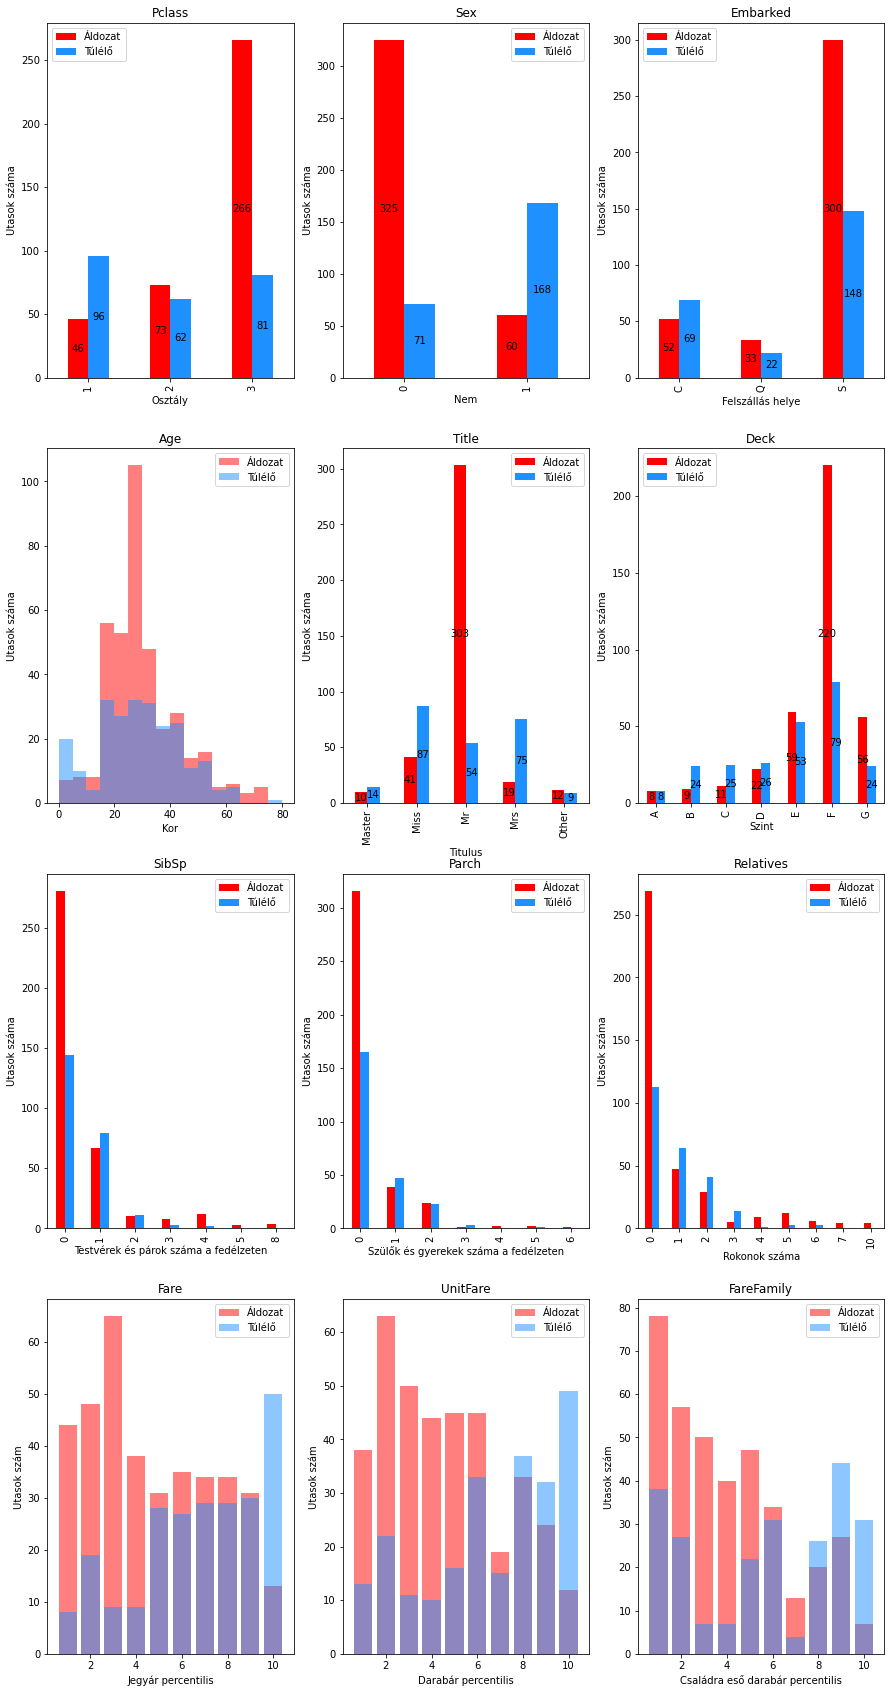

In [29]:
df_train_dead = df_train[df_train["Survived"] == 0]
df_train_survived = df_train[df_train["Survived"] == 1]


fig, axes = plt.subplots(nrows=4, ncols=3)
# fig.tight_layout(pad=1)
fig.set_size_inches(15,30)
df_pclass = pd.DataFrame({"Áldozat": df_train_dead.groupby("Pclass").count()["PassengerId"],
                          "Túlélő": df_train_survived.groupby("Pclass").count()["PassengerId"]})
ax = df_pclass.plot(kind='bar', color=['red', 'dodgerblue'], ax=axes[0,0])
ax.set_title("Pclass")
ax.set_xlabel("Osztály")
ax.set_ylabel("Utasok száma")
for i in ax.patches:
    ax.annotate(str(int(i.get_height())), xy=(i.get_x()+i.get_width()/2, i.get_height()/2), ha='center', va='center')

df_sex = pd.DataFrame({"Áldozat": df_train_dead.groupby("Sex").count()["PassengerId"],
                          "Túlélő": df_train_survived.groupby("Sex").count()["PassengerId"]})
ax = df_sex.plot(kind='bar', color=['red', 'dodgerblue'], ax=axes[0,1])
ax.set_title("Sex")
ax.set_xlabel("Nem")
ax.set_ylabel("Utasok száma")
for i in ax.patches:
    ax.annotate(str(int(i.get_height())), xy=(i.get_x()+i.get_width()/2, i.get_height()/2), ha='center', va='center')


  
df_embarked = pd.DataFrame({"Áldozat": df_train_dead.groupby("Embarked").count()["PassengerId"],
                          "Túlélő": df_train_survived.groupby("Embarked").count()["PassengerId"]})
ax = df_embarked.plot(kind='bar', color=['red', 'dodgerblue'], ax=axes[0,2])
ax.set_title("Embarked")
ax.set_xlabel("Felszállás helye")
ax.set_ylabel("Utasok száma")
for i in ax.patches:
    ax.annotate(str(int(i.get_height())), xy=(i.get_x()+i.get_width()/2, i.get_height()/2), ha='center', va='center')

df_age = pd.DataFrame({"Áldozat": df_train_dead["Age"],
                          "Túlélő": df_train_survived["Age"]})
ax = df_age.plot.hist(bins=np.arange(0,81,5), alpha=0.5, color=['red', 'dodgerblue'], ax=axes[1,0])
ax.set_title("Age")
ax.set_ylabel("Utasok száma")
ax.set_xlabel("Kor")

df_title = pd.DataFrame({"Áldozat": df_train_dead.groupby("Title").count()["PassengerId"],
                          "Túlélő": df_train_survived.groupby("Title").count()["PassengerId"]})
ax = df_title.plot(kind='bar', color=['red', 'dodgerblue'], ax=axes[1,1])
ax.set_title("Title")
ax.set_xlabel("Titulus")
ax.set_ylabel("Utasok száma")
for i in ax.patches:
    ax.annotate(str(int(i.get_height())), xy=(i.get_x()+i.get_width()/2, i.get_height()/2), ha='center', va='center')
    
df_deck = pd.DataFrame({"Áldozat": df_train_dead.groupby("Deck").count()["PassengerId"],
                          "Túlélő": df_train_survived.groupby("Deck").count()["PassengerId"]})
ax = df_deck.plot(kind='bar', color=['red', 'dodgerblue'], ax=axes[1,2])
ax.set_title("Deck")
ax.set_xlabel("Szint")
ax.set_ylabel("Utasok száma")
for i in ax.patches:
    ax.annotate(str(int(i.get_height())), xy=(i.get_x()+i.get_width()/2, i.get_height()/2), ha='center', va='center')
    
df_sibsp = pd.DataFrame({"Áldozat": df_train_dead.groupby("SibSp").count()["PassengerId"],
                          "Túlélő": df_train_survived.groupby("SibSp").count()["PassengerId"]})
ax = df_sibsp.plot(kind='bar', color=['red', 'dodgerblue'], ax=axes[2,0])
ax.set_title("SibSp")
ax.set_xlabel("Testvérek és párok száma a fedélzeten")
ax.set_ylabel("Utasok száma")
# for i in ax.patches:
#     ax.annotate(str(int(i.get_height())), xy=(i.get_x()+i.get_width()/2, i.get_height()/2), ha='center', va='center')

df_parch = pd.DataFrame({"Áldozat": df_train_dead.groupby("Parch").count()["PassengerId"],
                          "Túlélő": df_train_survived.groupby("Parch").count()["PassengerId"]})
ax = df_parch.plot(kind='bar', color=['red', 'dodgerblue'], ax=axes[2,1])
ax.set_title("Parch")
ax.set_xlabel("Szülők és gyerekek száma a fedélzeten")
ax.set_ylabel("Utasok száma")
# for i in ax.patches:
#     ax.annotate(str(int(i.get_height())), xy=(i.get_x()+i.get_width()/2, i.get_height()/2), ha='center', va='center')

df_relatives = pd.DataFrame({"Áldozat": df_train_dead.groupby("Relatives").count()["PassengerId"],
                          "Túlélő": df_train_survived.groupby("Relatives").count()["PassengerId"]})
ax = df_relatives.plot(kind='bar', color=['red', 'dodgerblue'], ax=axes[2,2])
ax.set_title("Relatives")
ax.set_xlabel("Rokonok száma")
ax.set_ylabel("Utasok száma")
# for i in ax.patches:
#     ax.annotate(str(int(i.get_height())), xy=(i.get_x()+i.get_width()/2, i.get_height()/2), ha='center', va='center')


fare_bins = [df_train["Fare"].quantile(i) for i in np.arange(0,1.1,0.1)]
fare_percentiles_dead = [len(df_train_dead[(df_train_dead["Fare"]<=fare_bins[i+1]) & (df_train_dead["Fare"]>fare_bins[i])]) for i in range(10)]
fare_percentiles_survived = [len(df_train_survived[(df_train_survived["Fare"]<=fare_bins[i+1]) & (df_train_survived["Fare"]>fare_bins[i])]) for i in range(10)]

ax=axes[3,0]
ax.bar(range(1,11),fare_percentiles_dead, alpha=0.5, label="Áldozat", color='red')
ax.bar(range(1,11),fare_percentiles_survived, alpha=0.5, label="Túlélő", color='dodgerblue')
ax.set_title("Fare")
ax.set_ylabel("Utasok szám")
ax.set_xlabel("Jegyár percentilis")
ax.legend()

unit_fare_bins = [df_train["UnitFare"].quantile(i) for i in np.arange(0,1.1,0.1)]
unit_fare_percentiles_dead = [len(df_train_dead[(df_train_dead["UnitFare"]<=unit_fare_bins[i+1]) & (df_train_dead["UnitFare"]>unit_fare_bins[i])]) for i in range(10)]
unit_fare_percentiles_survived = [len(df_train_survived[(df_train_survived["UnitFare"]<=unit_fare_bins[i+1]) & (df_train_survived["UnitFare"]>unit_fare_bins[i])]) for i in range(10)]

ax=axes[3,1]
ax.bar(range(1,11),unit_fare_percentiles_dead, alpha=0.5, label="Áldozat", color='red')
ax.bar(range(1,11),unit_fare_percentiles_survived, alpha=0.5, label="Túlélő", color='dodgerblue')
ax.set_title("UnitFare")
ax.set_ylabel("Utasok szám")
ax.set_xlabel("Darabár percentilis")
ax.legend()

family_fare_bins = [df_train["FareFamily"].quantile(i) for i in np.arange(0,1.1,0.1)]
family_fare_percentiles_dead = [len(df_train_dead[(df_train_dead["FareFamily"]<=unit_fare_bins[i+1]) & (df_train_dead["FareFamily"]>unit_fare_bins[i])]) for i in range(10)]
family_fare_percentiles_survived = [len(df_train_survived[(df_train_survived["FareFamily"]<=unit_fare_bins[i+1]) & (df_train_survived["FareFamily"]>unit_fare_bins[i])]) for i in range(10)]

ax=axes[3,2]
ax.bar(range(1,11),family_fare_percentiles_dead, alpha=0.5, label="Áldozat", color='red')
ax.bar(range(1,11),family_fare_percentiles_survived, alpha=0.5, label="Túlélő", color='dodgerblue')
ax.set_title("FareFamily")
ax.set_ylabel("Utasok szám")
ax.set_xlabel("Családra eső darabár percentilis")
ax.legend()
 

Az adatokat elemezve a túlélés függvényében néhány következtetést tudunk levonni:

Az első osztály utasainak 67.6%-a, a másod osztály utasainak a 46%-a, a harmadosztály utasainak 23.3%-a élte túl a balesetet, vagyis minnél magasabb osztályon utazott, annál jobb esélyei voltak.

A nők 73.68%-a, a férfiak 17.92%-a élte túl a balesetet.

Cherbourgban felszálló utasoknak a többiektől eltérően nagyobb aránya túlélte a balesetet.

A legroszabb túlélési aránya a 15 és 35 közöttieknek volt, a gyerekek és idősebbek túlélési esélyei sokkal jobbak voltak.

Mr. titulussal voltak kiemelkedően a legroszabb túlélsi esélyei egy utasnak, ennek oka, hogy mindannyian férfiak és jellemzően idősebbek voltak, nagy részük pedig alacsonyabb társadalmi osztályhoz tartozott.

Az alacsonyabb szinten lakó utasoknak alacsonyabb a túlélési esélyük is, ez az osztálllyal áll összefüggésben.

Azon utasoknak, akiknek 0, vagy több mint 3 rokonuk volt a fedélzeten, szembetűnően rosszabb túlélési esélyük volt.

A jegyár esetén az alsó 4 percentilis túlélési esélyei alacsonyak, míg a 10. percentilis túlélési esélyei kifejezetten magasak. Ez is az osztállyal van összefüggésben.

Az egy főre jutó átlagos jegyár, valamint az egy családtagra jutó átlagos jegyár tekintetében is jellemzően a legdrágább jegyű utasok élték túl nagyobb számban, azonban nem egyenletes a többi percentilis esetén a növekedés.

In [30]:
# fig, ax = plt.subplots(figsize=(15,15))

# sn.violinplot(y ="Age", x ="Sex", hue ="Survived", data = df_train, split = True, palette=['red', 'dodgerblue'], inner="quartile", bw=.1, ax=ax)
# sn.swarmplot(y ="Age", x ="Sex", hue ="Survived", data = df_train, dodge = True, palette=['black', 'black'], ax=ax, alpha=0.5, size=3)
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles[:2], labels[:2])

Text(0.5, 0, 'Kor')

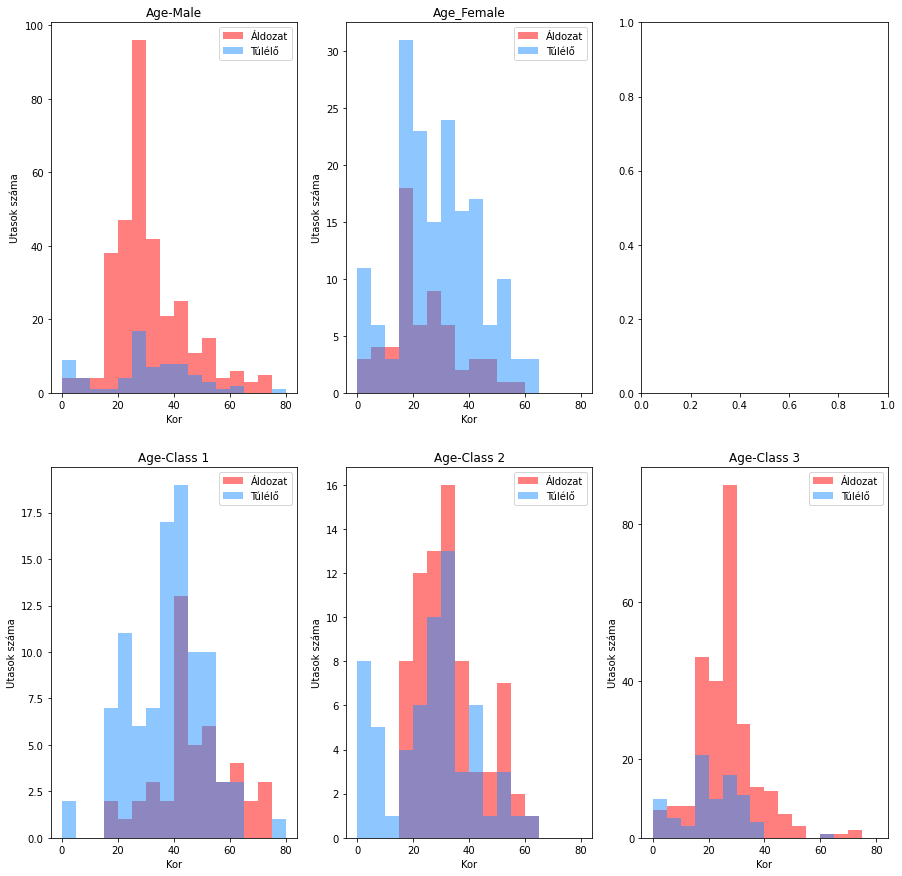

In [31]:
df_male = df_train[df_train["Sex"]==0]
df_female = df_train[df_train["Sex"]==1]

fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches(15,15)
df_age_male = pd.DataFrame({"Áldozat": df_male[df_male["Survived"]==0]["Age"],
                          "Túlélő": df_male[df_male["Survived"]==1]["Age"]})
ax = df_age_male.plot.hist(bins=np.arange(0,81,5), alpha=0.5, color=['red', 'dodgerblue'], ax=axes[0,0])
ax.set_title("Age-Male")
ax.set_ylabel("Utasok száma")
ax.set_xlabel("Kor")

df_female = pd.DataFrame({"Áldozat": df_female[df_female["Survived"]==0]["Age"],
                          "Túlélő": df_female[df_female["Survived"]==1]["Age"]})
ax = df_female.plot.hist(bins=np.arange(0,81,5), alpha=0.5, color=['red', 'dodgerblue'], ax=axes[0,1])
ax.set_title("Age_Female")
ax.set_ylabel("Utasok száma")
ax.set_xlabel("Kor")


df_c1 = df_train[df_train["Pclass"]==1]
df_c2= df_train[df_train["Pclass"]==2]
df_c3= df_train[df_train["Pclass"]==3]

df_age_c1 = pd.DataFrame({"Áldozat": df_c1[df_c1["Survived"]==0]["Age"],
                          "Túlélő": df_c1[df_c1["Survived"]==1]["Age"]})
ax = df_age_c1.plot.hist(bins=np.arange(0,81,5), alpha=0.5, color=['red', 'dodgerblue'], ax=axes[1,0])
ax.set_title("Age-Class 1")
ax.set_ylabel("Utasok száma")
ax.set_xlabel("Kor")

df_age_c2 = pd.DataFrame({"Áldozat": df_c2[df_c2["Survived"]==0]["Age"],
                          "Túlélő": df_c2[df_c2["Survived"]==1]["Age"]})
ax = df_age_c2.plot.hist(bins=np.arange(0,81,5), alpha=0.5, color=['red', 'dodgerblue'], ax=axes[1,1])
ax.set_title("Age-Class 2")
ax.set_ylabel("Utasok száma")
ax.set_xlabel("Kor")

df_age_c3 = pd.DataFrame({"Áldozat": df_c3[df_c3["Survived"]==0]["Age"],
                          "Túlélő": df_c3[df_c3["Survived"]==1]["Age"]})
ax = df_age_c3.plot.hist(bins=np.arange(0,81,5), alpha=0.5, color=['red', 'dodgerblue'], ax=axes[1,2])
ax.set_title("Age-Class 3")
ax.set_ylabel("Utasok száma")
ax.set_xlabel("Kor")

A férfiak közül a 30 év körüliek esetén kifejezetten rossz a túlélési arány, a 10 év alattiak esetén jelentősen jobb az arányuk.

Nők esetén a legveszélyesebb korosztály a 10-20 éves korosztályban a legroszabb a túlélési arány, azonban sehol sem olyan rossz, mint a férfiak esetén átlagosan.

Az első osztályon a 40 év alattiak esetén magas a túlélési arány, efelett még mindig kiemelkedő, azonban látványosan rosszabb.
A másodosztályon 15 év alatt nincsen áldozat, felette változó arányban élték túl az emberek.

A legroszabb a harmadosztályon a helyzet, itt egyedül az 5 év alattiak közül élték többen túl, mint estek áldozatul a balesetnek. 25 év felett nagyon alacsony a túlélők aránya.

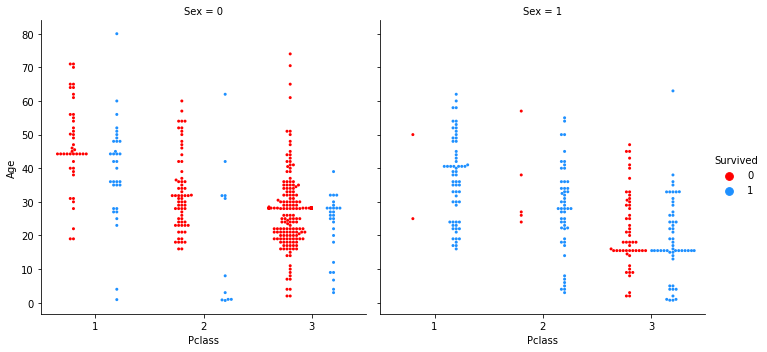

In [32]:
sn.catplot(y ="Age", x ="Pclass", hue ="Survived", data = df_train, dodge = True, palette=['red', 'dodgerblue'], kind="swarm", col="Sex", s=3)

df_train_ = df_train.copy(deep=True)
df_train_["AgeG"]=df_train_["Age"]/10
df_train_["AgeG"] = df_train_["AgeG"].apply(np.floor)
df_train_["AgeG"]=df_train_["AgeG"]*10

In [33]:
print(df_train_.groupby(["Sex", "Pclass", "AgeG"]).mean()["Survived"])
print(df_train_.groupby(["Sex", "Pclass", "AgeG"]).count()["Survived"])

Sex  Pclass  AgeG
0    1       0.0     1.000000
             10.0    0.000000
             20.0    0.750000
             30.0    0.583333
             40.0    0.400000
             50.0    0.333333
             60.0    0.142857
             70.0    0.000000
             80.0    1.000000
     2       0.0     1.000000
             10.0    0.000000
             20.0    0.000000
             30.0    0.115385
             40.0    0.142857
             50.0    0.000000
             60.0    0.500000
     3       0.0     0.384615
             10.0    0.058824
             20.0    0.111940
             30.0    0.125000
             40.0    0.000000
             50.0    0.000000
             60.0    0.000000
             70.0    0.000000
1    1       10.0    1.000000
             20.0    0.916667
             30.0    1.000000
             40.0    1.000000
             50.0    0.900000
             60.0    1.000000
     2       0.0     1.000000
             10.0    1.000000
             20.0    0

A nemet, kort és osztályt együtt vigyálva láthatjuk, hogy a nők közül szinte szinte senki nem esett áldozatul az első osztályon, keveseb a másodosztályon és jellemzően idősebbek, míg a harmadosztályon jelentősebb az elhúnytak aránya, főleg az idősebb korosztályban.

A férfiak esetén a fiatalok között a legjobbak a túlélési arányok, olyannyira, hogy rosszabbak a túlélési arányok az elsőosztály idősei között, mint a másodosztály fiataljai között.

In [34]:
def break_categorical(df_):
    df = df_.copy(deep=True)
    
    one_hot = pd.get_dummies(df["Deck"], prefix="Deck")
    df = df.join(one_hot)

    one_hot = pd.get_dummies(df["Title"], prefix="Title")
    df = df.join(one_hot)

    one_hot = pd.get_dummies(df["Pclass"], prefix="Pclass")
    df = df.join(one_hot)

    one_hot = pd.get_dummies(df["Embarked"], prefix="Embarked")
    df = df.join(one_hot)
    
    df_return = pd.DataFrame()
    if "Survived" in df.columns:
        for column in ["Survived", "Sex", "Age", "Alone", "Fare", "Room", "FareFamily", "Deck_A", "Deck_B", "Deck_C", "Deck_D", "Deck_E", "Deck_F", "Deck_G", "Title_Master", "Title_Miss", "Title_Mr", "Title_Mrs", "Title_Other", "Pclass_1", "Pclass_2", "Pclass_3", "Embarked_C", "Embarked_Q", "Embarked_S"]:
            try:
                df_return[column] = df[column]
            except:
                df_return[column] = 0
    else:
        for column in ["Sex", "Age", "Alone", "Fare", "Room", "FareFamily", "Deck_A", "Deck_B", "Deck_C", "Deck_D", "Deck_E", "Deck_F", "Deck_G","Title_Master", "Title_Miss", "Title_Mr", "Title_Mrs", "Title_Other", "Pclass_1", "Pclass_2", "Pclass_3", "Embarked_C", "Embarked_Q", "Embarked_S"]:
            try:
                df_return[column] = df[column]
            except:
                df_return[column] = 0
    print(df_return.columns)
    
    return df_return

In [35]:
def break_categorical_convert_to_num(df_):
    df = df_.copy(deep=True)
    
    deck_map={"A": 1, "B": 2, "C":3, "D": 4, "E": 5, "F": 6, "G": 7}

    for key in Counter(df["Deck"]).keys():
        if not key in deck_map.keys():
            deck_map[key] = "8"
    
    df = df.replace({"Deck": deck_map})

    one_hot = pd.get_dummies(df["Title"], prefix="Title")
    df = df.join(one_hot)

    one_hot = pd.get_dummies(df["Embarked"], prefix="Embarked")
    df = df.join(one_hot)
    
    df_return = pd.DataFrame()
    if "Survived" in df.columns:
        for column in ["Survived", "Sex", "Age", "Alone", "Fare", "Room", "FareFamily", "Deck", "Title_Master", "Title_Miss", "Title_Mr", "Title_Mrs", "Title_Other", "Pclass", "Embarked_C", "Embarked_Q", "Embarked_S"]:
            try:
                df_return[column] = df[column]
            except:
                df_return[column] = 0
    else:
        for column in ["Sex", "Age", "Alone", "Fare", "Room", "FareFamily", "Deck", "Title_Master", "Title_Miss", "Title_Mr", "Title_Mrs", "Title_Other", "Pclass", "Embarked_C", "Embarked_Q", "Embarked_S"]:
            try:
                df_return[column] = df[column]
            except:
                df_return[column] = 0
     
    return df_return

A fedélzet száma, a titulus, az osztály és a felszállás helye kategórikus értékek, ezek értékeire célszerű lehet klön oszlopokat létrehozni, azonban az osztály és a fedélzet száma értelmezhető folytonos értékként is. Mindkét lehetőséget megvizsgálom a későbbiekben. A kort, valamint a jegyárat is kategóriákra (korcsoport, illetve a jegyárak percentilise alapján), de ezeket egyelőre folytonos változóként hagoym meg.

In [36]:
df_train = transform_database(df_train_orig)
df_test = transform_database(df_test_orig)

df_train_num = break_categorical_convert_to_num(df_train)      
df_test_num = break_categorical_convert_to_num(df_test)

df_train_cat = break_categorical(df_train)      
df_test_cat = break_categorical(df_test)

Index(['Survived', 'Sex', 'Age', 'Alone', 'Fare', 'Room', 'FareFamily',
       'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G',
       'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Other',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q',
       'Embarked_S'],
      dtype='object')
Index(['Sex', 'Age', 'Alone', 'Fare', 'Room', 'FareFamily', 'Deck_A', 'Deck_B',
       'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Other', 'Pclass_1',
       'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')


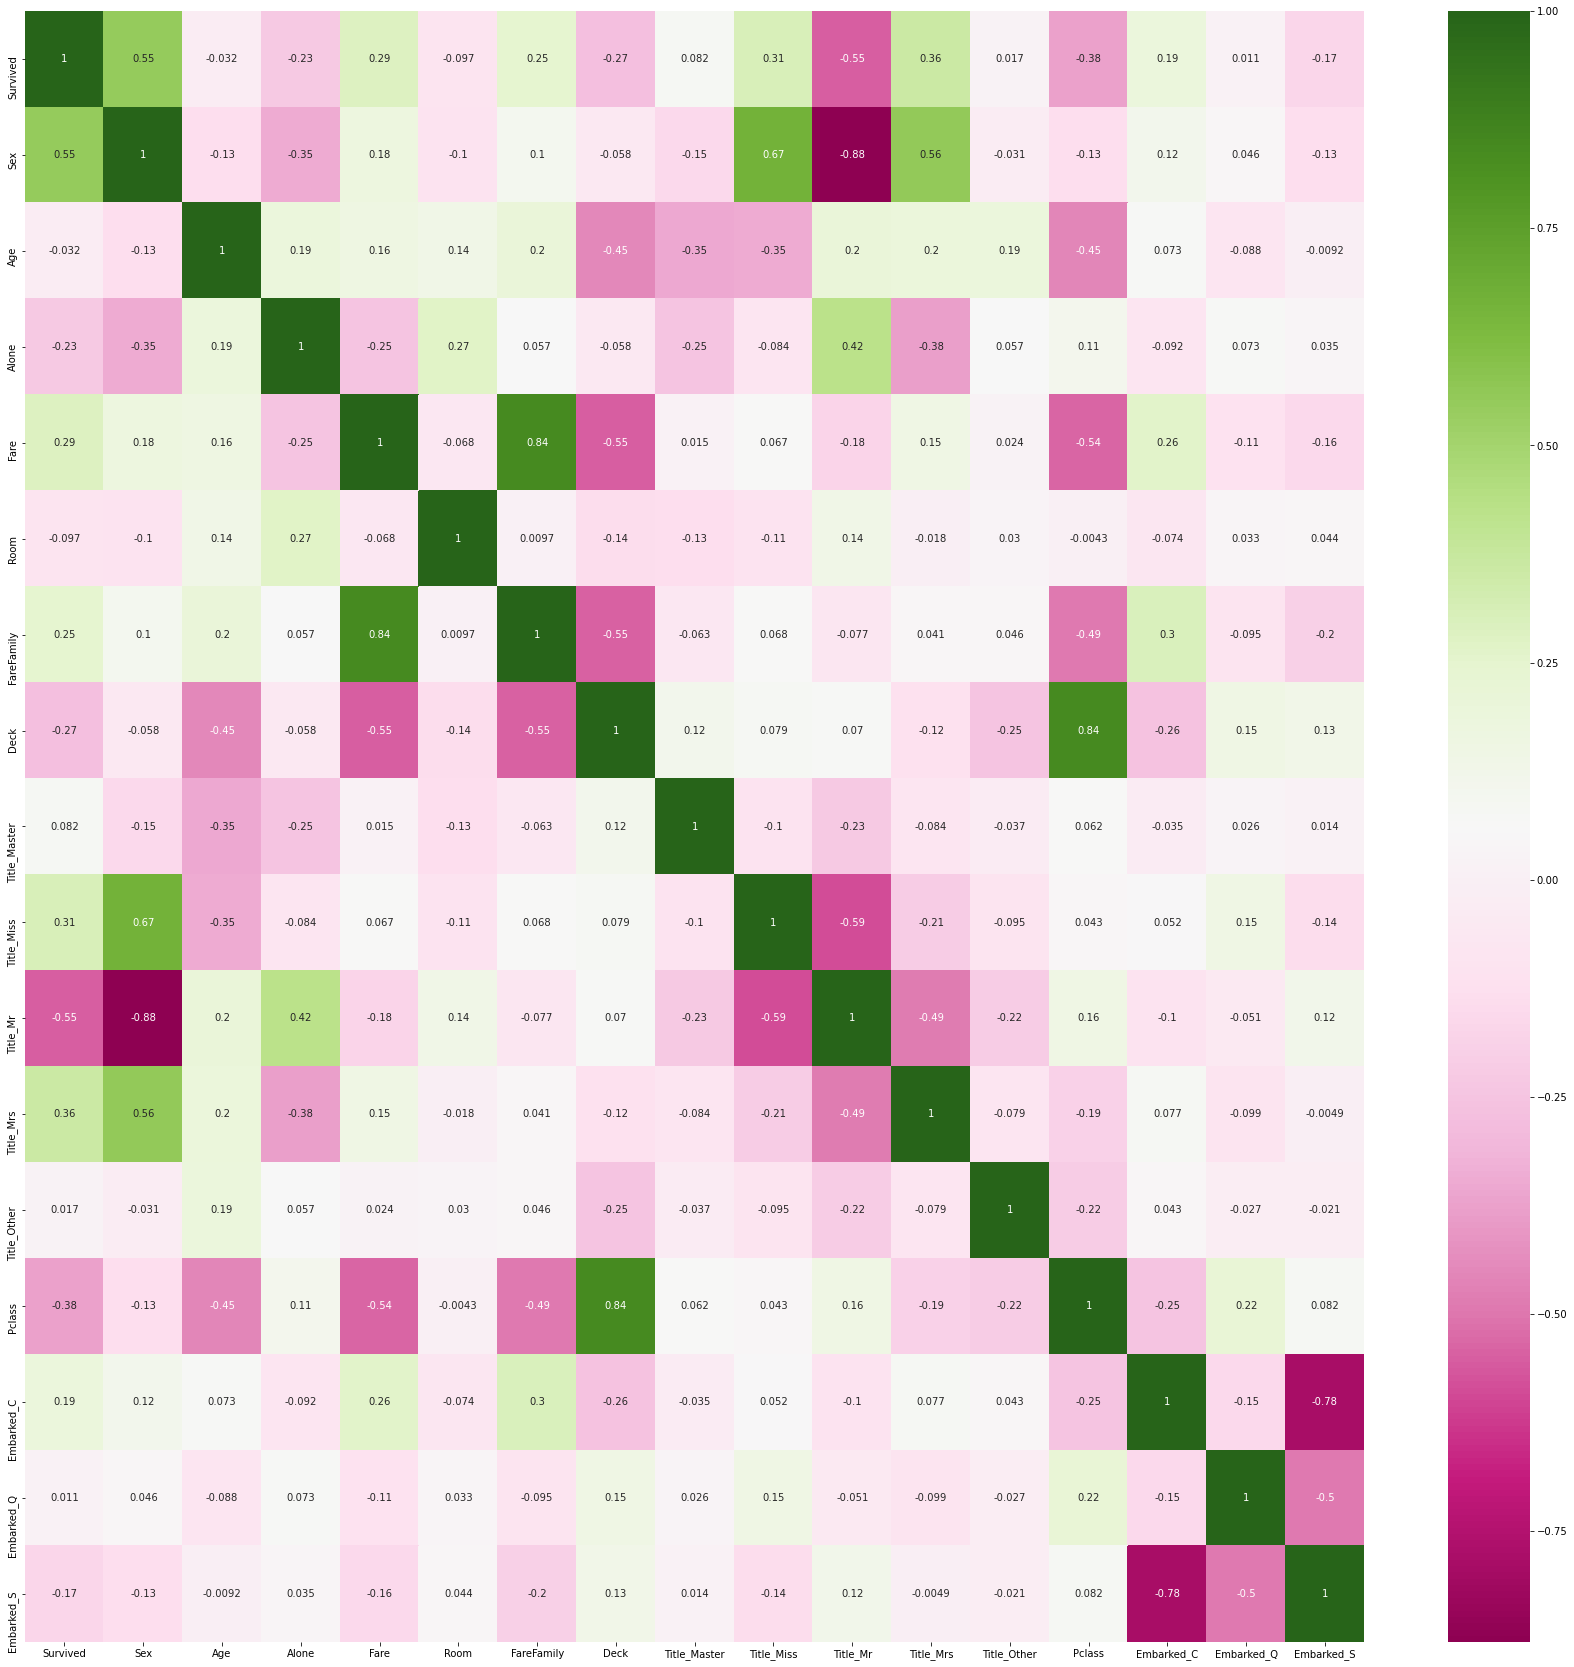

In [37]:
corrMatrix = df_train_num.corr()
plt.figure(figsize=(30,30))
sn.heatmap(corrMatrix, annot=True, cmap="PiYG")
plt.show()

A túléléssel a legnagyobb korrelációt a nem, a Mr., Miss és Mrs. titulus (amely a nemtől függ), az osztály, a jegyár (amely szintén függ az osztálytól), a szint (amely szintén az osztálytól függ), hogy egyedül van-e (ők jelelmzően férfiak) valamint némileg kevésbé, de a felszállás helye (amely szintén egy alacsony korrelációt mutat az osztállyal). A kor esetén a linerási korreláció alacsony, ennek oka, hogy nem lináris a kapcsolat a túlélés és a kor között, a fiatalabb és idősebb generációk esetén jobbak az esélyek.

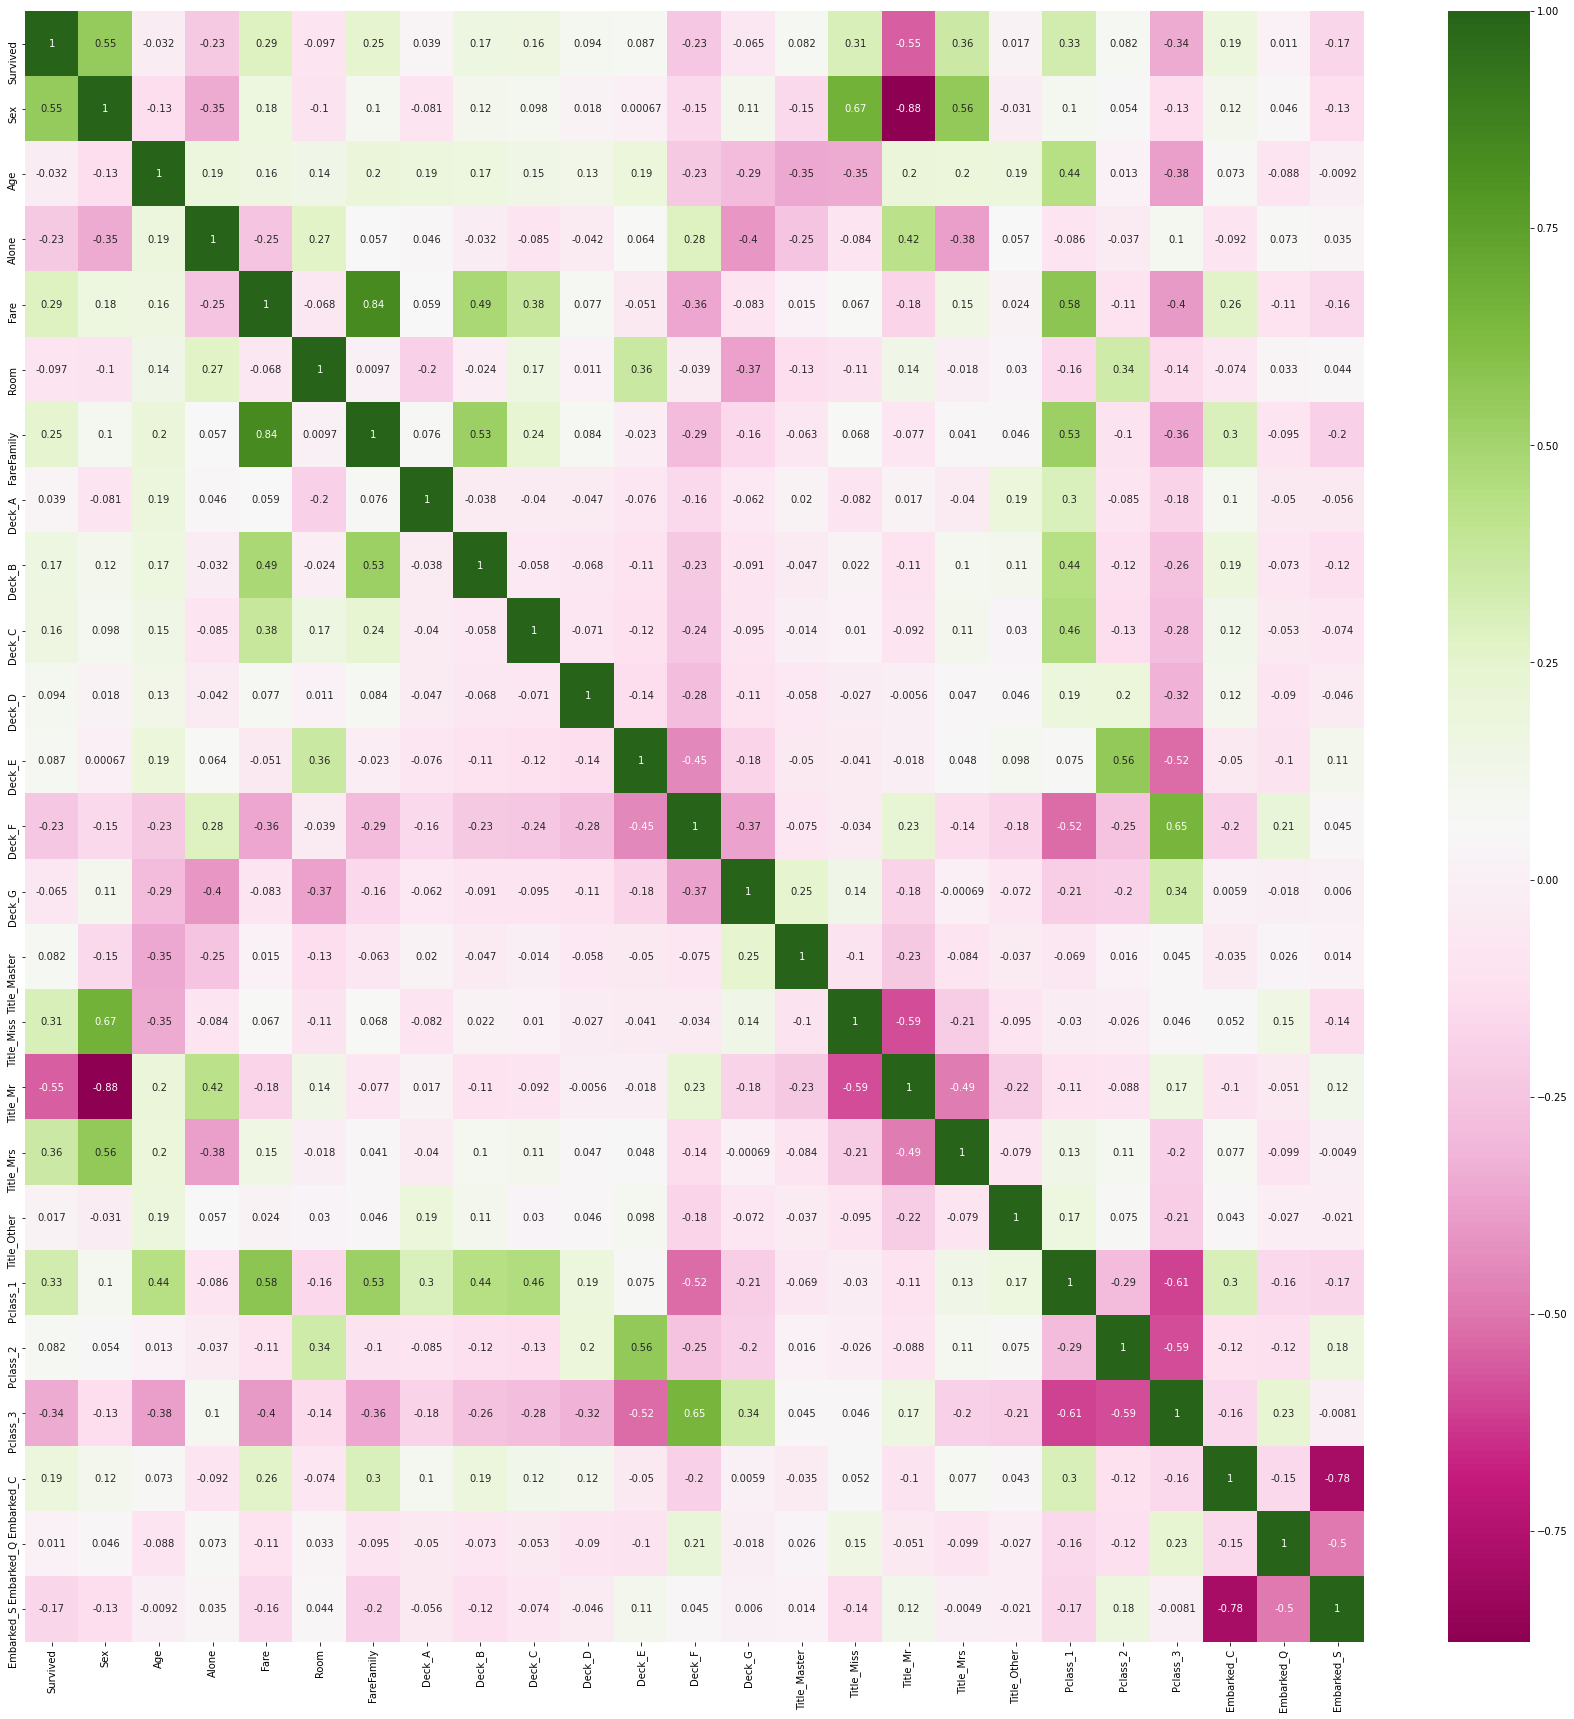

In [38]:
corrMatrix = df_train_cat.corr()
plt.figure(figsize=(30,30))
sn.heatmap(corrMatrix, annot=True, cmap="PiYG")
plt.show()

Az osztály és szint változókat kategórikus változóként kezelve látszik, hogy a túléléssel való korreláció az osztály esetén szimmetrikus, az első osztályon pozitív, a másodosztályon közel 0, míg a harmadosztályon negatív a korreláció. Az A szint kivételével a többi szinten is folyamatosan csökken a túléléssel a korreláció.

## Modell építés

A modell egyszerűségének igénye miatt egy döntési fát választok amely mélységének meghatározása a feladat. A túlillesztés elkerülése érdekében K-fold cross validation-t használok 100-as értékkel. Kiválasztom, hogy milyen előfeldolgozás után kapom a legjobb eredményt, majd ellenőrzöm, hogy a választott modell által adott értékek értelmezhetőek-e valószínűségként.

In [39]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import tree

In [41]:
df_train = transform_database(df_train_orig)
df_test = transform_database(df_test_orig)

df_train_num = break_categorical_convert_to_num(df_train)      
df_test_num = break_categorical_convert_to_num(df_test)

df_train_cat = break_categorical(df_train)      
df_test_cat = break_categorical(df_test)

X_train = df_train_num.drop(["Survived"], axis=1)
Y_train = df_train_num["Survived"]

X_test = df_test_num

Index(['Survived', 'Sex', 'Age', 'Alone', 'Fare', 'Room', 'FareFamily',
       'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G',
       'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Other',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q',
       'Embarked_S'],
      dtype='object')
Index(['Sex', 'Age', 'Alone', 'Fare', 'Room', 'FareFamily', 'Deck_A', 'Deck_B',
       'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Other', 'Pclass_1',
       'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')


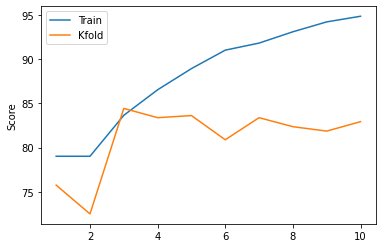

In [42]:
train_values = []
test_values = []
valid_values = []

for i in range(1,11):

    decision_tree = DecisionTreeClassifier(max_depth=i)
    decision_tree.fit(X_train, Y_train)
    acc_decision_tree_train = round(decision_tree.score(X_train, Y_train) * 100, 2)
    acc_decision_tree_valid = round(cross_val_score(decision_tree, X_train, Y_train, cv=100, scoring = "accuracy").mean()*100,2)
    train_values.append(acc_decision_tree_train)
    valid_values.append(acc_decision_tree_valid)

plt.plot(range(1,11), train_values, label="Train")
plt.plot(range(1,11), list(valid_values), label="Kfold")
plt.legend()
plt.ylabel("Score")
plt.show()

In [43]:
decision_tree = DecisionTreeClassifier(max_depth=3)
decision_tree.fit(X_train, Y_train)
acc_decision_tree_valid = round(cross_val_score(decision_tree, X_train, Y_train, cv=100, scoring = "accuracy").mean()*100,2)
acc_decision_tree_train = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree_valid,acc_decision_tree_train

(84.43, 83.65)

In [45]:
df_train_cat = break_categorical(df_train)      
df_test_cat = break_categorical(df_test)

X_train = df_train_cat.drop(["Survived"], axis=1)
Y_train = df_train_cat["Survived"]

X_test = df_test_cat

Index(['Survived', 'Sex', 'Age', 'Alone', 'Fare', 'Room', 'FareFamily',
       'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G',
       'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Other',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q',
       'Embarked_S'],
      dtype='object')
Index(['Sex', 'Age', 'Alone', 'Fare', 'Room', 'FareFamily', 'Deck_A', 'Deck_B',
       'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Other', 'Pclass_1',
       'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')


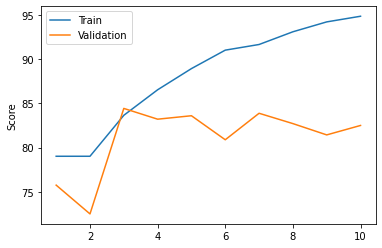

In [46]:
train_values = []
valid_values = []

for i in range(1,11):

    decision_tree = DecisionTreeClassifier(max_depth=i)
    decision_tree.fit(X_train, Y_train)
    acc_decision_tree_train = round(decision_tree.score(X_train, Y_train) * 100, 2)
    acc_decision_tree_valid = round(cross_val_score(decision_tree, X_train, Y_train, cv=100, scoring = "accuracy").mean()*100,2)
    train_values.append(acc_decision_tree_train)
    valid_values.append(acc_decision_tree_valid)

plt.plot(range(1,11), train_values, label="Train")
plt.plot(range(1,11), valid_values, label="Validation")
plt.legend()
plt.ylabel("Score")
plt.show()

In [47]:
decision_tree = DecisionTreeClassifier(max_depth=3)
decision_tree.fit(X_train, Y_train)
acc_decision_tree_valid = round(cross_val_score(decision_tree, X_train, Y_train, cv=100, scoring = "accuracy").mean()*100,2)
acc_decision_tree_train = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree_valid,acc_decision_tree_train

(84.43, 83.65)

Mindkét esetben a 3 mélységű fa adta a legjobb eredményt, mindkét esetben ugyan azt, ezért végül az egyszerűség kedvéért a kategórikus előfeldolgozást választom. A döntéshez a Sex, FareFamily, Pclass, Fare és Age attribútumokat használom.

Érdekesség, hogy 1-esmélységű döntési fával, amely csak a nem alapján dönt, se sokkal rosszabb eredményt lehet elérni, amennyiben a modell egyszerűsége kritikus, érdemes lehet ezt választani.

In [48]:
decision_tree = DecisionTreeClassifier(max_depth=1)
decision_tree.fit(X_train, Y_train)
acc_decision_tree_valid = round(cross_val_score(decision_tree, X_train, Y_train, cv=100, scoring = "accuracy").mean()*100,2)
acc_decision_tree_train = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree_valid,acc_decision_tree_train

(75.74, 79.01)

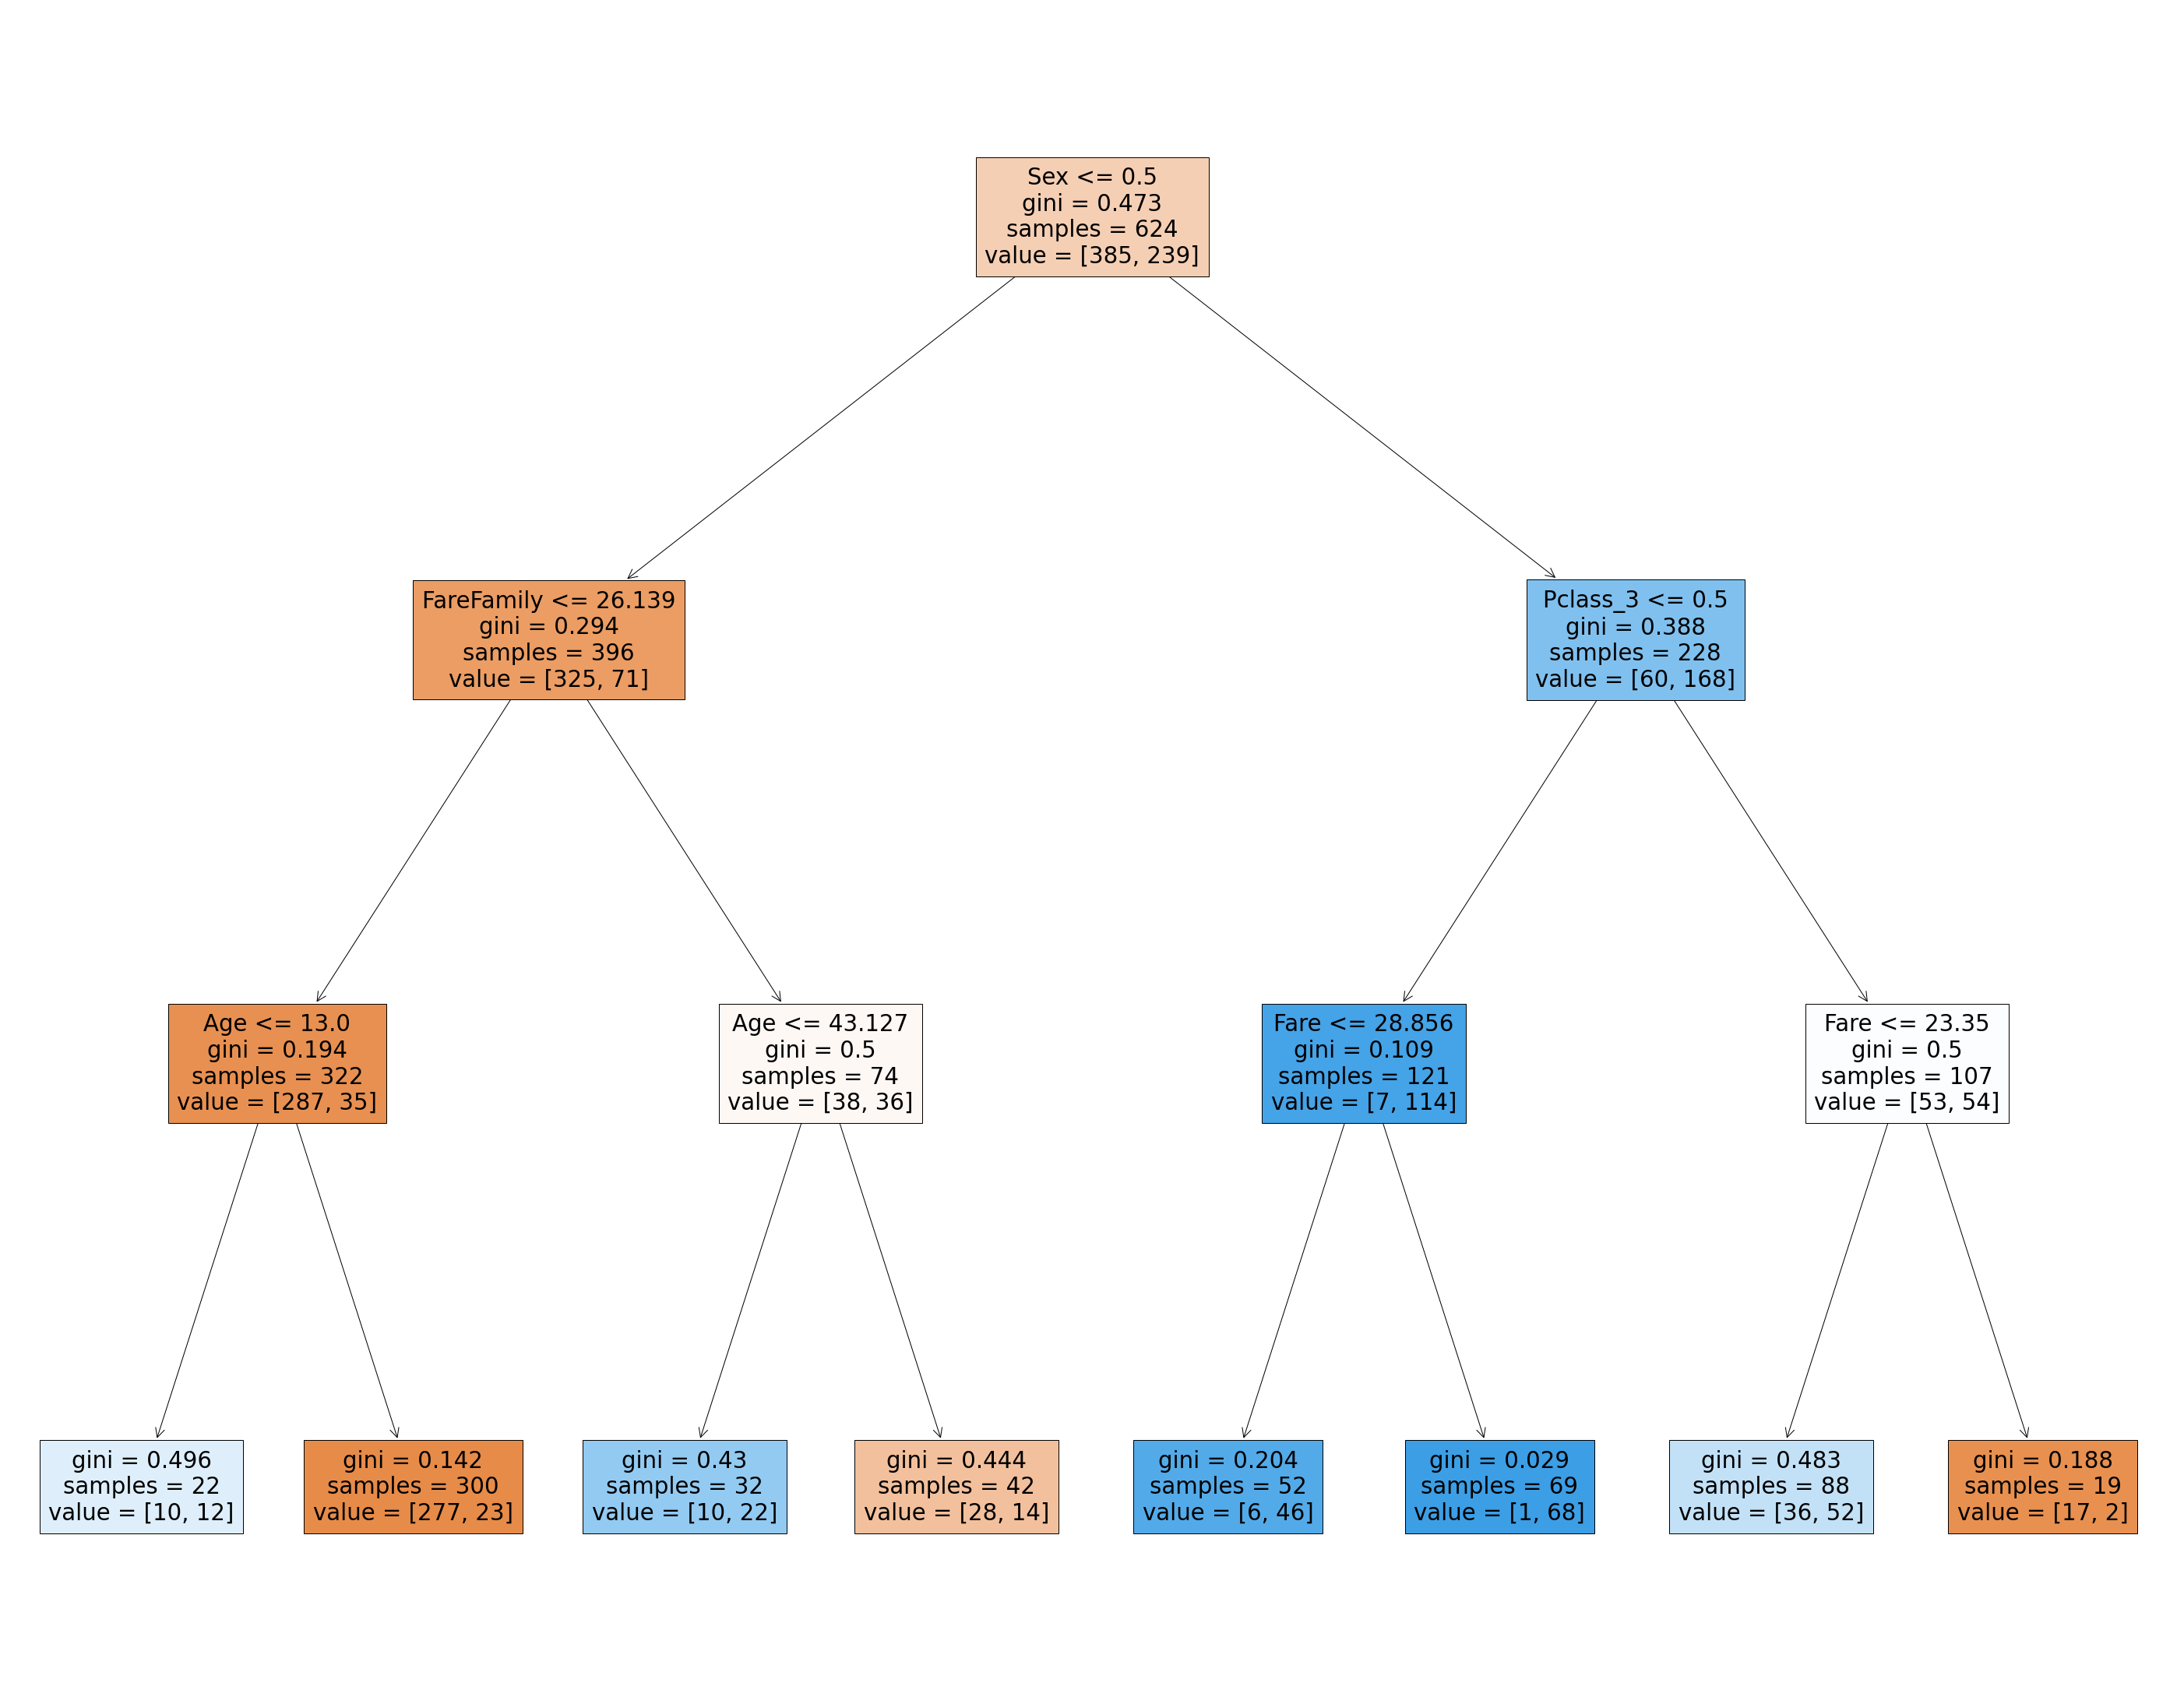

In [51]:
decision_tree = DecisionTreeClassifier(max_depth=3)
decision_tree.fit(X_train, Y_train)
fig = plt.figure(figsize=(50,40))
_ = tree.plot_tree(decision_tree,feature_names=X_train.columns,
                   filled=True ) 


In [52]:
prob_train = decision_tree.predict_proba(X_train)

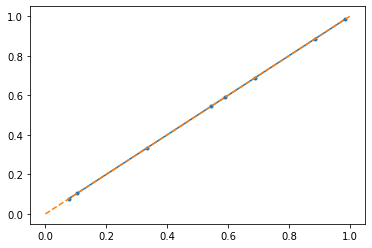

In [53]:
from sklearn.calibration import calibration_curve

mpv, fop = calibration_curve(Y_train, prob_train[:,1].T, n_bins=20)
plt.plot(fop, mpv, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')

In [54]:
prob_train = decision_tree.predict_proba(X_test)
prob_train[:,1]

array([0.98550725, 0.07666667, 0.33333333, 0.54545455, 0.59090909,
       0.88461538, 0.07666667, 0.07666667, 0.59090909, 0.07666667,
       0.07666667, 0.6875    , 0.07666667, 0.88461538, 0.98550725,
       0.33333333, 0.54545455, 0.88461538, 0.07666667, 0.6875    ,
       0.07666667, 0.07666667, 0.54545455, 0.07666667, 0.88461538,
       0.07666667, 0.07666667, 0.33333333, 0.07666667, 0.07666667,
       0.07666667, 0.59090909, 0.6875    , 0.07666667, 0.07666667,
       0.07666667, 0.10526316, 0.33333333, 0.07666667, 0.59090909,
       0.07666667, 0.6875    , 0.07666667, 0.59090909, 0.07666667,
       0.88461538, 0.07666667, 0.07666667, 0.6875    , 0.6875    ,
       0.07666667, 0.07666667, 0.07666667, 0.07666667, 0.07666667,
       0.07666667, 0.59090909, 0.54545455, 0.07666667, 0.88461538,
       0.07666667, 0.54545455, 0.10526316, 0.07666667, 0.6875    ,
       0.33333333, 0.54545455, 0.54545455, 0.54545455, 0.88461538,
       0.07666667, 0.07666667, 0.07666667, 0.88461538, 0.98550

A teszt adatok esetén a túlélés valószínűségét a prob_train változó tartalmazza.